# Experiments with MNIST Dataset and Attentive Gate MoE Training

The experiments in this notebook include training the attentive gate MoE models as follows:

1. attentive gate MoE without regularization.
2. attentive gate MoE with $L_{importance}$ regularization.
3. attentive gate MoE with $L_s$ regularization.

In [49]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [50]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [51]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [52]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")
print('device', device)

device cuda:0


In [53]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best performance
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [54]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)        

In [55]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) #mean and standard deviation computed from the dataset

In [56]:
# Complete train and test data
trainsize = 60000
testsize = 10000

In [148]:
batch_size = 512

In [57]:
# Load data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 512
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


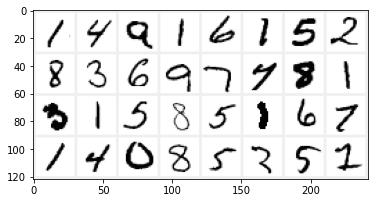

In [58]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [59]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
                
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        # print('conv1', t.shape)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # print('max pool', t.shape)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
                      
        self.hidden = t
            
        t = F.relu(t)
                
        # output
        t = F.softmax(self.out(t), dim=1) # The temperature parameter is 1 for all the experiments
        
        return t

In [60]:
# Attentive gate
# Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_attn_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
                
    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        return t


In [61]:
# Original gate
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [62]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers, channels=1):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes, channels))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [63]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train attentive gate model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [84]:
def train_with_attention(model_1, trainloader, testloader, runs, temps=[[1.0]*20], w_importance_range=[0], 
                         w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20, channels=1):
    
    hidden = 32
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff, in product(temps, w_importance_range,w_sample_sim_same_range,  w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        n_run_models_1 = []
        for run in range(1,runs+1):

            print('Run:', run), 

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes, channels=channels).to(device)
                
                gate_model = gate_attn_layers(total_experts, channels).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, 
                                           w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            
            if  os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
        print(plot_file)

### Function to distill the attentive gate model to the original model

In [85]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                     trainloader=None, testloader=None, expert_no_grad=True, gate_no_grad=False):
    
    T = [1.0]*num_epochs
    for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,  
                                       w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
    
        for model in attn_models: 
            # Initialise the new expert weights to the weights of the experts of the trained attentive gate model.
            # Fix all the weights of the new experts so they are not trained.
            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if expert_no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            # Initialise the new gate weights to the weights of the gate of the trained attentive gate model.
            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)

            if gate_no_grad:
                for param in new_gate_model.parameters():
                    param.requires_grad = False
                new_gate_model.out = nn.Linear(in_features=32, out_features=num_experts)
                
            gate_model = new_gate_model

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)                

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate= gate_model).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            print(plot_file)
            



## Experiments

### Experiment 1: Attentive gate MoE model training

In [97]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_with_attention_hidden_32'

In [98]:
total_experts = 5

In [99]:
num_epochs = 20

In [114]:
runs = 10

In [101]:
train_with_attention(model_1, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.36 , training accuracy 0.57 , test accuracy 0.83
epoch 1 training loss 0.48 , training accuracy 0.86 , test accuracy 0.88
epoch 2 training loss 0.38 , training accuracy 0.89 , test accuracy 0.89
epoch 3 training loss 0.35 , training accuracy 0.90 , test accuracy 0.90
epoch 4 training loss 0.33 , training accuracy 0.90 , test accuracy 0.91
epoch 5 training loss 0.31 , training accuracy 0.91 , test accuracy 0.91
epoch 6 training loss 0.29 , training accuracy 0.91 , test accuracy 0.92
epoch 7 training loss 0.26 , training accuracy 0.92 , test accuracy 0.92
epoch 8 training loss 0.24 , training accuracy 0.93 , test accuracy 0.93
epoch 9 training loss 0.22 , training accuracy 0.93 , test accuracy 0.93
epoch 10 training loss 0.21 , training accuracy 0.94 , test accuracy 0.93
epoch 11 training loss 0.20 , training accuracy 0.94 , test accuracy 0.93
epoch 12 training loss 0.19 , training accuracy 0.94 ,

### Experiment 2: Attentive gate MoE model training with $L_{importance}$ regularization

In [102]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_attn_reg_hidden_32'

In [103]:
total_experts = 5

In [104]:
num_epochs = 20

In [115]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']


In [116]:
runs = 10

In [107]:
train_with_attention(model_2, trainloader, testloader, runs, w_importance_range=w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 1.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.49 , training accuracy 0.55 , test accuracy 0.82
epoch 1 training loss 0.51 , training accuracy 0.87 , test accuracy 0.92
epoch 2 training loss 0.31 , training accuracy 0.92 , test accuracy 0.93
epoch 3 training loss 0.25 , training accuracy 0.93 , test accuracy 0.94
epoch 4 training loss 0.21 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.20 , training accuracy 0.95 , test accuracy 0.95
epoch 6 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 7 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 9 training loss 0.15 , training accuracy 0.96 , test accuracy 0.96
epoch 10 training loss 0.14 , training accuracy 0.96 , test accuracy 0.96
epoch 11 training loss 0.13 , training accuracy 0.96 , test accuracy 0.96
epoch 12 training loss 0.13 , training accuracy 0.97 ,

### Experiment 3: Attentive gate MoE model training with sample similarity $L_s$ regularization

In [108]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_with_attn_sample_sim_reg_hidden_32'

In [109]:
total_experts = 5

In [110]:
num_epochs = 20

In [118]:
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [1e-06, 1e-05]
w_sample_sim_diff_range =  [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [119]:
runs = 10

In [113]:
train_with_attention(model_3, trainloader, testloader, runs,
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 0.1
Run: 1
epoch 0 training loss 1.46 , training accuracy 0.63 , test accuracy 0.89
epoch 1 training loss 0.51 , training accuracy 0.91 , test accuracy 0.93
epoch 2 training loss 0.40 , training accuracy 0.94 , test accuracy 0.94
epoch 3 training loss 0.36 , training accuracy 0.95 , test accuracy 0.95
epoch 4 training loss 0.34 , training accuracy 0.96 , test accuracy 0.95
epoch 5 training loss 0.33 , training accuracy 0.96 , test accuracy 0.96
epoch 6 training loss 0.32 , training accuracy 0.96 , test accuracy 0.96
epoch 7 training loss 0.31 , training accuracy 0.97 , test accuracy 0.96
epoch 8 training loss 0.30 , training accuracy 0.97 , test accuracy 0.97
epoch 9 training loss 0.29 , training accuracy 0.97 , test accuracy 0.96
epoch 10 training loss 0.28 , training accuracy 0.97 , test accuracy 0.97
epoch 11 training loss 0.28 , training accuracy 0.97 , test accuracy 0.97
epoch 12 training loss 0.27 , training accuracy 0.98

### Experiment 4: Distilling attentive gate MoE model

#### Distilling attentive gate MoE model with $L_{importance}$ regularization

In [88]:
m = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=trainloader, testloader=testloader)

w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
epoch 0 training loss 0.59 , training accuracy 0.83 , test accuracy 0.90
epoch 1 training loss 0.26 , training accuracy 0.92 , test accuracy 0.93
epoch 2 training loss 0.22 , training accuracy 0.93 , test accuracy 0.94
epoch 3 training loss 0.20 , training accuracy 0.94 , test accuracy 0.94
epoch 4 training loss 0.19 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 6 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 0.16 , training accuracy 0.95 , test accuracy 0.94
epoch 8 training loss 0.16 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.15 , training accuracy 0.95 , test accuracy 0.95
epoch 10 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 12 training loss 0.14 , training accuracy 0.96 , test a

#### Distilling attentive gate MoE model with $L_{s}$ regularization

In [89]:
m = 'mnist_with_attn_sample_sim_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

train_from_model(m, num_epochs, num_classes, total_experts, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                 trainloader=trainloader, testloader=testloader)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 1e-06
epoch 0 training loss 0.74 , training accuracy 0.79 , test accuracy 0.89
epoch 1 training loss 0.33 , training accuracy 0.90 , test accuracy 0.91
epoch 2 training loss 0.26 , training accuracy 0.92 , test accuracy 0.92
epoch 3 training loss 0.23 , training accuracy 0.93 , test accuracy 0.93
epoch 4 training loss 0.20 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.19 , training accuracy 0.95 , test accuracy 0.94
epoch 6 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 7 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.16 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.14 , training accuracy 0.96 , test accuracy 0.95
epoch 12 training loss 0.14 , training accuracy 0.96 , te

## Results

### Collect the train error, test error, mutual information $I(E;Y)$, sample entropy $H_s$ and expert usage entropy $H_u$ for all the models trained with MNIST dataset. Store the reuslts in the '../results/mnist_results.csv' file.

In [135]:
# Compute the expert usage entropy 
def expert_usage_entropy(history, total_experts=5, num_epochs=20):
    gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
    gate_probabilities_sum = torch.mean(gate_probability[-1,:,:].view(-1,total_experts), dim=0)
    return entropy(gate_probabilities_sum).item()

In [138]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0], w_ortho_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename='mnist_results.csv'):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(pre_trained_model_path, 'mnist', plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]    
                # model
                model = mod['moe_expectation_model']['experts'][total_experts]['model']
                # history
                history = mod['moe_expectation_model']['experts'][total_experts]['history']
                # train error
                data.append(1-history['accuracy'][-1].item())
                
                running_test_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                
                # initialise the count matrix C for computing mutual information
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    running_test_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                test_error = 1-(running_test_accuracy/num_batches)
                data.append(test_error.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

#### Collect results for all the trained models

In [139]:
total_experts = 5
num_classes = 10
num_epochs = 20

In [140]:
m = 'mnist_without_reg_hidden_32'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [141]:
m = 'mnist_with_reg_hidden_32'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [142]:
m = 'mnist_with_reg_hidden_32'
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [143]:
m = 'mnist_with_attention_hidden_32'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [144]:
m = 'mnist_with_attn_reg_hidden_32'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [145]:
m = 'mnist_with_attn_sample_sim_reg_hidden_32'
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [146]:
m = 'new_mnist_with_attn_reg_hidden_32'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path)

In [147]:
m = 'new_mnist_with_attn_sample_sim_reg_hidden_32'
w_sample_sim_same_range = [1e-6,1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                testloader=testloader, model_path=model_path, results_path=results_path)

### Final results

#### These are the final performance results, reported in the paper, on the test data for the model with the minimum training error for each category of MoE model and training method.

In [149]:
import pandas as pd
filename = os.path.join(results_path, 'mnist_results.csv')
data = pd.read_csv(filename)

In [150]:
final_results_filename = os.path.join(results_path, 'mnist_final_results.csv')

In [152]:
models = ['mnist_single_model', 'mnist_without_reg_hidden_32', 'mnist_with_reg_hidden_32_importance', 
          'mnist_with_reg_hidden_32_sample', 'mnist_with_attention', 'mnist_with_attn_reg_hidden_32_importance',
          'mnist_with_attn_sample_sim_reg_hidden_32_sample', 'new_mnist_with_attn_reg_hidden_32_importance',
          'new_mnist_with_attn_sample_sim_reg_hidden_32_sample']
header = True
for i, m in enumerate(models):
    if i:
        header = False
    # select model with the minimum train error
    row = data.loc[[data[data['filename'].str.startswith(m)]['train error'].idxmin()]]
    # compute the std of test error over the 10 runs
    std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['test error'].std())
    row['val error std'] = std
    row.to_csv(final_results_filename, mode='a', header=header, index=False, float_format='%.3f')

In [153]:
# display final results
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

,filename,train error,test error,mutual information,sample entropy,expert usage,val error std
0,mnist_single_model_hidden_32_5,0.097,0.096,NA,NA,NA,0.071
1,mnist_without_reg_hidden_32_10_5_models.pt,0.021,0.038,2.022,0.092,2.172,0.009
2,mnist_with_reg_hidden_32_importance_0.2_10_5_m...,0.015,0.032,2.262,0.061,2.32,0.008
3,mnist_with_reg_hidden_32_sample_sim_same_1e-06...,0.015,0.029,2.244,0.051,2.246,0.009
4,mnist_with_attention_hidden_32_10_5_models.pt,0.019,0.033,1.797,0.071,2.055,0.006
5,mnist_with_attn_reg_hidden_32_importance_0.2_1...,0.013,0.035,2.26,0.055,2.266,0.005
6,mnist_with_attn_sample_sim_reg_hidden_32_sampl...,0.013,0.032,2.275,0.039,2.321,0.006
7,new_mnist_with_attn_reg_hidden_32_importance_0...,0.009,0.030,2.301,0.036,2.32,0.007
8,new_mnist_with_attn_sample_sim_reg_hidden_32_s...,0.009,0.028,2.191,0.056,2.319,0.007
